In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
from scipy.stats import spearmanr, pearsonr

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

#celltype = 'all'
master_dir = '../'

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [4]:
# Name of results file 
results_file_all_genes = master_dir + 'data/PBMC_processed/disease_comparisons/normalized_MAGIC_ALL_MONO.h5ad'
#results_file_metab_genes = master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad'

# Read in counts matrix
#adata_cd8 = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_CD8.h5ad')
#adata_cd4 = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_CD4.h5ad')
#adata_b = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_B_wo_patient4.h5ad')
#adata_nk = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_NK.h5ad')
#adata_mono = sc.read_h5ad(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_MONOCYTES.h5ad')

In [5]:
#adata.write(master_dir + 'data/PBMC_processed/fo8_thru_in8_GEX_for_ALL.h5ad')
adata = sc.read_h5ad(results_file_all_genes)

In [6]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
#for geneset in metab_genes.index:
#    if metab_genes.loc[geneset, 1] not in metab_pathway_list:
#        metab_genes = metab_genes.drop(geneset, axis=0)
metab_pathway_list = metab_genes.index
metab_genes.head()

,1,2,3,4,5,6,7,8,9,10,...,124,125,126,127,128,129,130,131,132,133
0,,,,,,,,,,,,,,,,,,,,,
Glycolysis / Gluconeogenesis,LDHC,HK3,LDHB,PFKP,ALDOA,ALDOB,ADH6,GAPDHS,DLAT,PGM1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Citrate cycle (TCA cycle),DLST,ACO1,CS,IDH3B,ACLY,SUCLG2,DLAT,IDH3A,SUCLA2,PDHB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pentose phosphate pathway,PFKP,ALDOA,RPIA,ALDOB,H6PD,RPE,RPEL1,PRPS1L1,PFKM,RBKS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pentose and glucuronate interconversions,UGT2B4,UGT2A1,XYLB,CRYL1,UGT2B17,UGT1A3,UGDH,UGT1A4,UGT1A8,UGP2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fructose and mannose metabolism,HK3,PFKFB3,PFKP,FCSK,ALDOA,ALDOB,GFUS,TPI1,PMM2,SORD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Get a flat array of metabolism-related genes
metab_gene_list = np.array(metab_genes.iloc[:, 1:]).flatten().astype(str)
metab_gene_list = metab_gene_list[metab_gene_list != 'nan']
len(metab_gene_list)

2841

In [8]:
# Make a new data object with only the metabolic genes from the KEGG pathways
metab_gene_list_overlap = list(set(metab_gene_list).intersection(set(adata.var_names)))
adata_metab = adata[:, metab_gene_list_overlap]
len(metab_gene_list_overlap)

1102

In [9]:
# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))
    #metab_genes_dict[element] = metab_genes_dict[element][metab_genes_dict[element] != 'nan']
#metab_genes_dict['Glycolysis / Glucogeneogenesis_test'] = ['ACSS1', 'GAPDH']

In [10]:
#sc.tl.pca(adata, svd_solver='arpack')

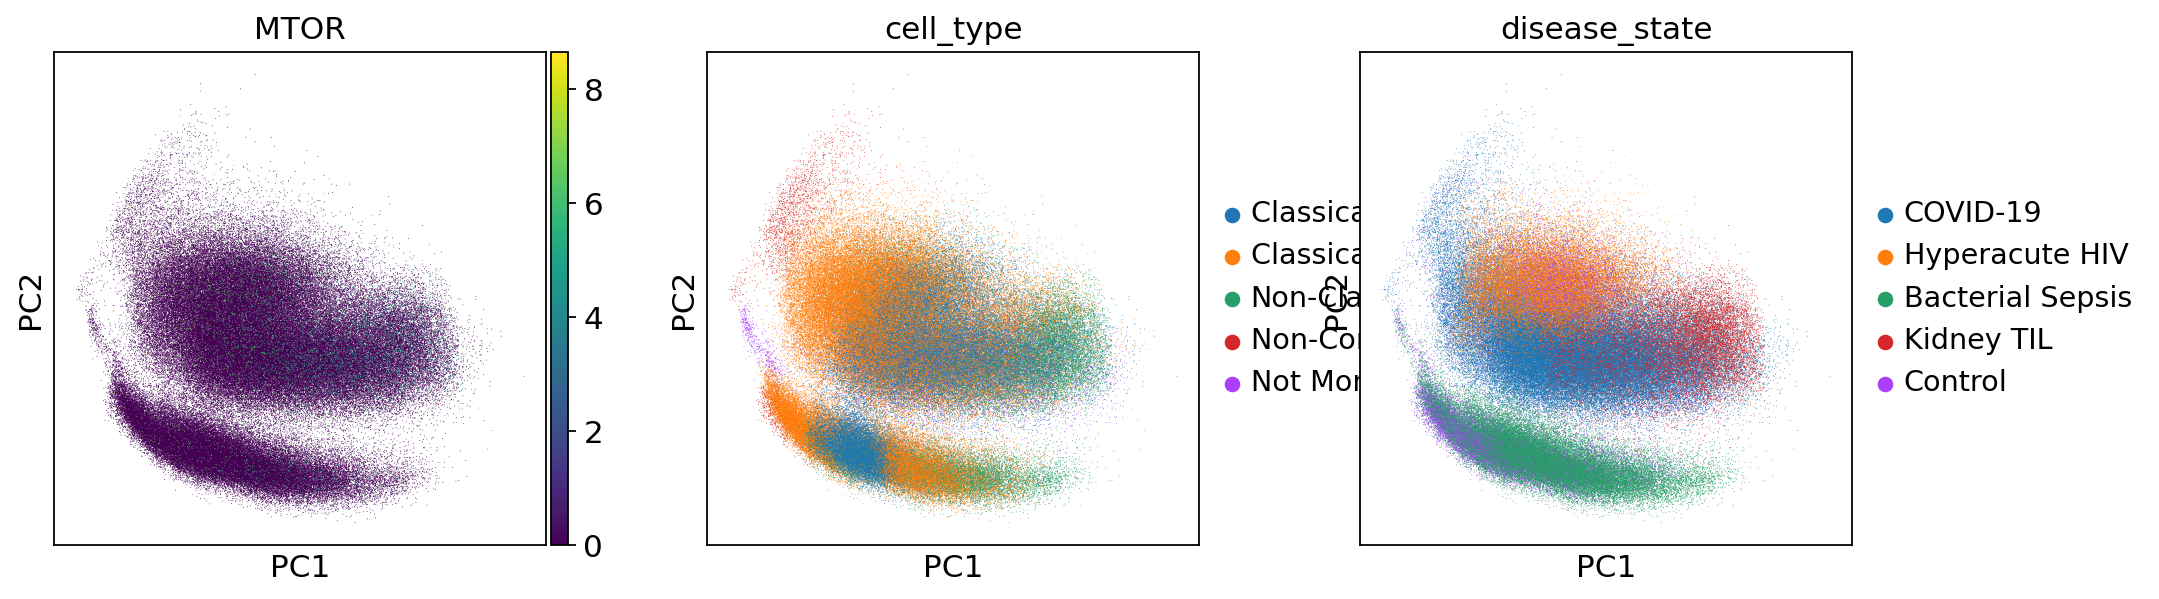

In [11]:
fig = sc.pl.pca(adata, color=['MTOR', 'cell_type', 'disease_state'])

In [12]:
#sc.pl.pca_variance_ratio(adata, log=True)

In [13]:
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)

In [14]:
# Relabel leiden and louvain because they are per cell type
#adata.obs['leiden_per_cell_type'] = adata.obs['leiden'].copy()
#adata.obs['louvain_per_cell_type'] = adata.obs['louvain'].copy()
#adata.obs = adata.obs.drop(columns=['leiden', 'louvain'])
#adata.obs = adata.obs.drop(columns=['louvain'])

In [15]:
#sc.tl.louvain(adata, resolution=0.1)

In [16]:
# Reorder cell type colors to be consistent with the flux analysis plot
#adata.uns['cell_type_colors'] = ['#279e68', '#ff7f0e', '#1f77b4', '#aa40fc', '#d62728']

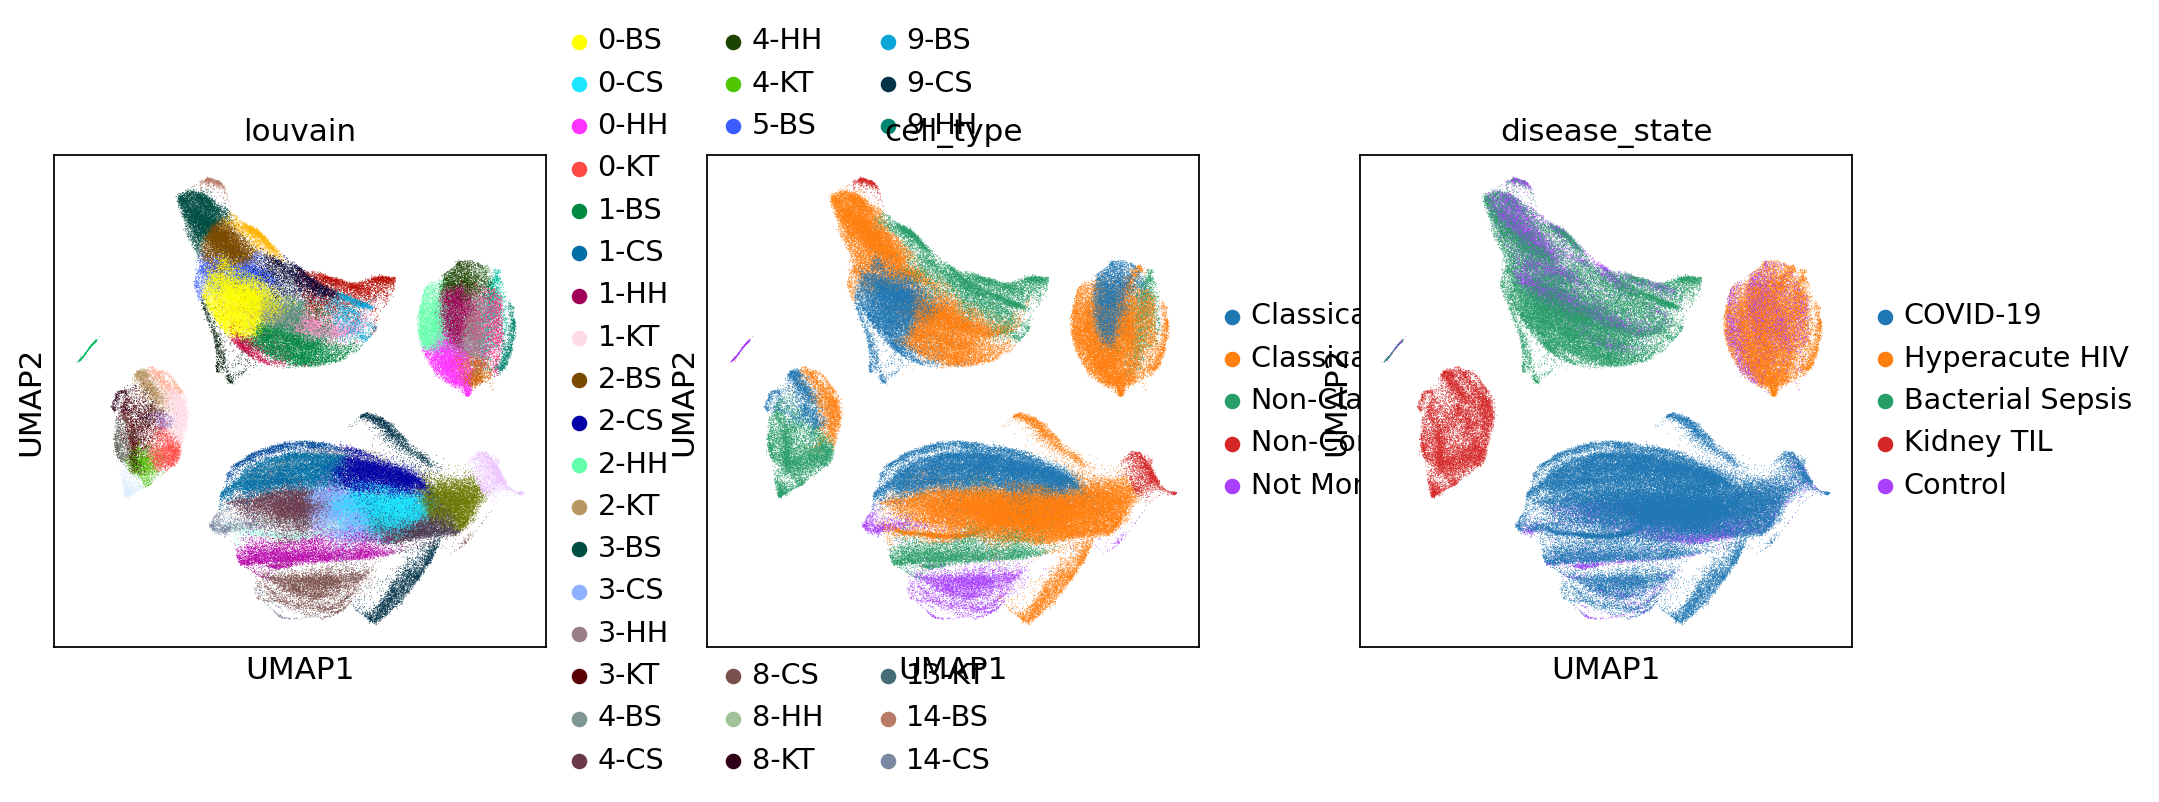

In [17]:
fig = sc.pl.umap(adata, color=['louvain', 'cell_type', 'disease_state'])

In [48]:
#adata.obs['Days_since_onset_float'] = adata.obs['Days_since_onset_of_symptoms'].apply(lambda x:float(x) if x!= 'Healthy' else -1).astype(float)

In [49]:
#fig = sc.pl.umap(adata, color=['patient', 'ICU_status', 'WHO_scale', 'Days_since_onset_float'], use_raw=False)

In [50]:
#sc.tl.embedding_density(adata, basis='umap', groupby='ICU_status')

In [51]:
#sc.pl.embedding_density(adata, basis='umap', key='umap_density_ICU_status')

In [ ]:
#adata.write(master_dir + 'output/all-processed-analyzed.h5ad')

## Clustering by metabolic genes only

In [18]:
# New AnnData containing metabolic genes only
adata_metab = adata[:, adata.var_names.isin(metab_gene_list)]

In [19]:
sc.tl.pca(adata_metab, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:28)


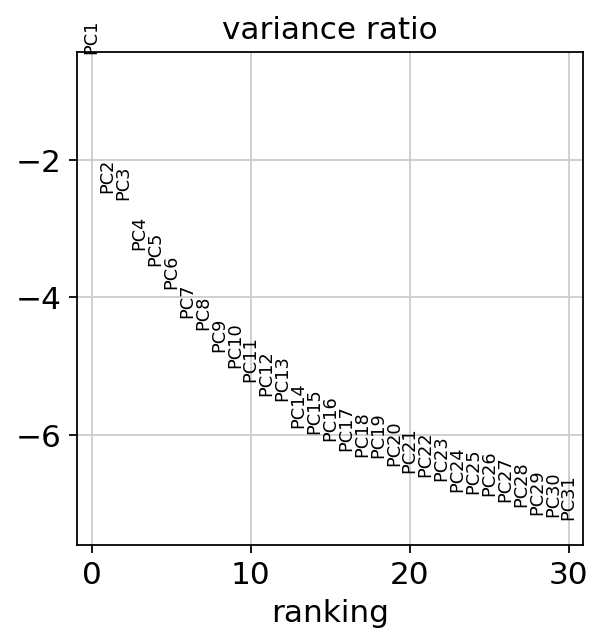

In [20]:
sc.pl.pca_variance_ratio(adata_metab, log=True)

In [21]:
sc.pp.neighbors(adata_metab)
sc.tl.umap(adata_metab, min_dist=0.1)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:06:34)


In [22]:
adata_metab.obs['louvain_all'] = adata_metab.obs['louvain'].copy()
adata_metab.obs = adata_metab.obs.drop(columns=['louvain'])

In [23]:
sc.tl.louvain(adata_metab, resolution=0.1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:42)


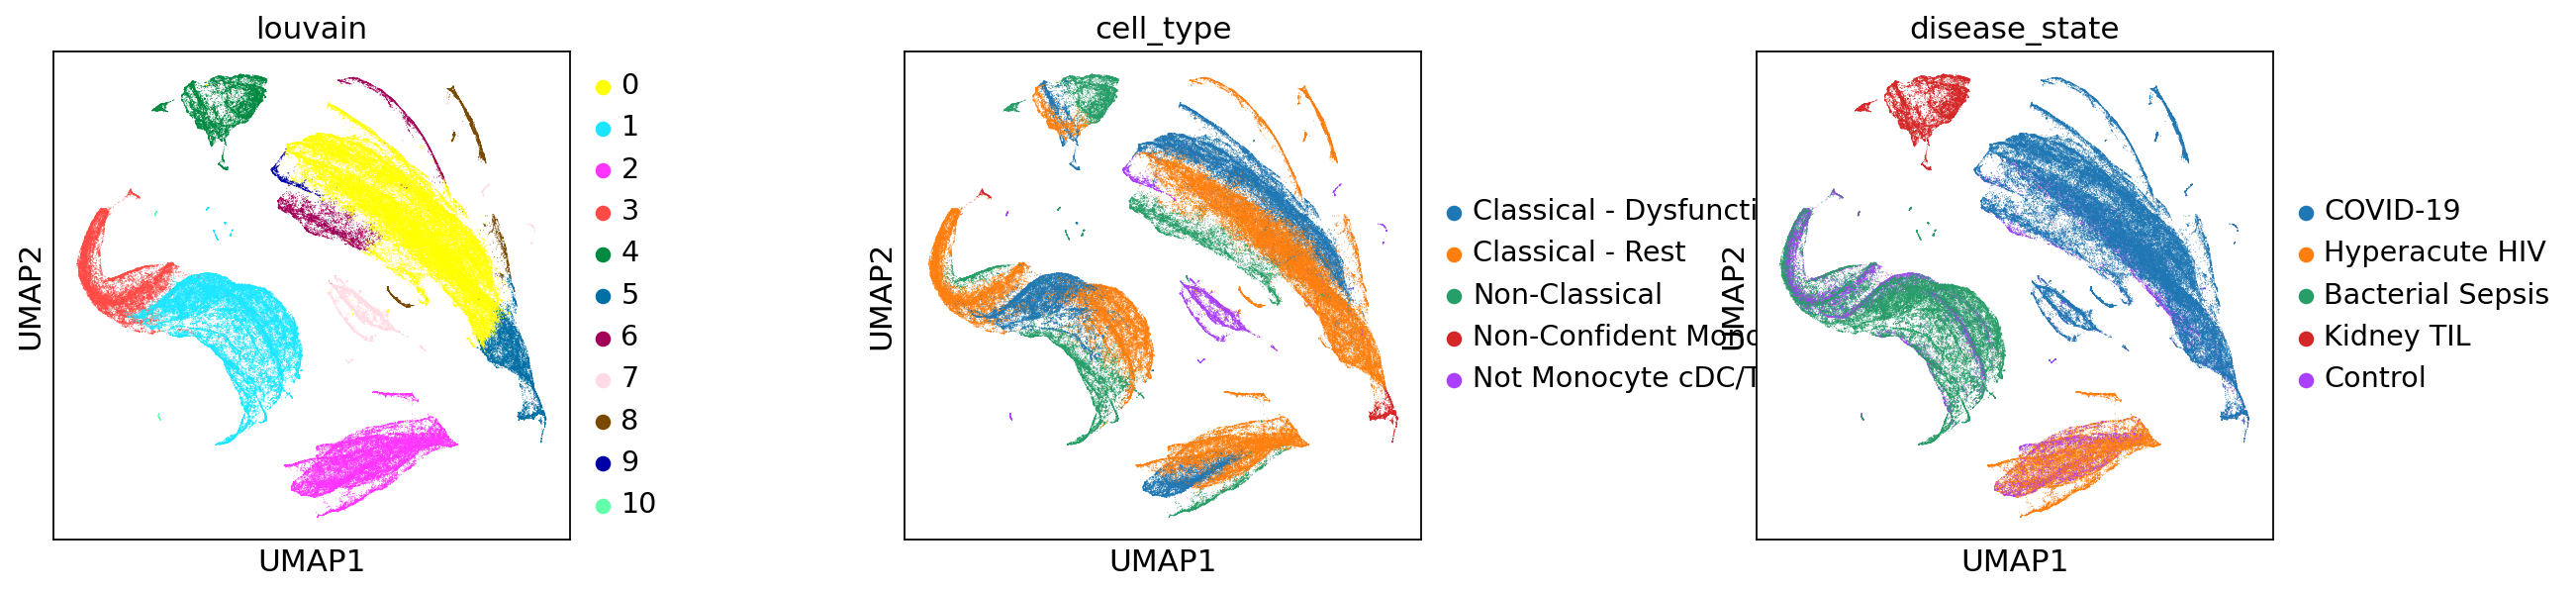

In [24]:
fig = sc.pl.umap(adata_metab, color=['louvain', 'cell_type', 'disease_state'], wspace=0.5)

In [25]:
#adata_metab.write(master_dir + 'output/disease_comparisons/disease-comparison-metab-Monocyte.h5ad')

In [10]:
# Read the above processed file
adata_metab = sc.read(master_dir + 'output/disease_comparisons/disease-comparison-metab-Monocyte.h5ad')

In [11]:
# Function for stacked bar plots to compare metabolic and all-gene clusters
def plot_bar(adata, x, y, df, kind, out, ax=None, stacked=True, colors=None, \
    rotation=0, xorder=None, yorder=None, cmap=None, **kwargs):

    if kind=='Frequency':
        props = df.groupby(x)[y].value_counts(normalize=True).unstack()
    elif kind=='Count':
        props = df.groupby(x)[y].value_counts(normalize=False).unstack()

    if xorder is not None:
        props = props.loc[xorder]
    if yorder is not None:
        props = props.loc[:, yorder]
    # stacked barplot
    with sns.axes_style('ticks'):
        if cmap is not None:
            colors = [cmap[col] for col in props.columns]
        elif y+'_colors' in adata.uns:
            palette = adata.uns[y+'_colors']
            categories = adata.obs[y].cat.categories
            cmap = {cat:color for cat, color in zip(categories, palette)}
            colors = [cmap[cat] for cat in props.columns]
        if stacked:
            ax = props.plot(kind='bar', stacked='True', color=colors, ax=ax, **kwargs)
        else:
            ax = props.plot(kind='bar', stacked=None, color=colors, ax=ax, **kwargs)
        ax.legend(bbox_to_anchor=(1.2,0.8))
        sns.despine()
        ax.set_ylabel(kind)
        ax.set_xlabel(x)
        ax.tick_params(axis='x', which='major', labelrotation=rotation)
        fig = ax.get_figure()
        fig.savefig('{}/{}_{}_{}{}.pdf'.format(out, x,y,kind, '_stacked'*stacked), \
            bbox_inches='tight', transparent=True)
        plt.close()
    return 

In [12]:
adata_metab.obs['cell_type'].unique()

['Non-Classical', 'Classical - Dysfunctional', 'Classical - Rest', 'Not Monocyte cDC/T/B', 'Non-Confident Monocyte']
Categories (5, object): ['Non-Classical', 'Classical - Dysfunctional', 'Classical - Rest', 'Not Monocyte cDC/T/B', 'Non-Confident Monocyte']

In [13]:
adata_metab.obs['disease_state'].unique()

['Control', 'COVID-19', 'Hyperacute HIV', 'Bacterial Sepsis', 'Kidney TIL']
Categories (5, object): ['Control', 'COVID-19', 'Hyperacute HIV', 'Bacterial Sepsis', 'Kidney TIL']

In [16]:
# Discard non monocytes and monocytes on the borderline (unconfident PE)
data_metab = adata_metab[adata_metab.obs['cell_type'].isin(['Non-Classical', 'Classical - Dysfunctional',
                        'Classical - Rest'])]
data_metab = data_metab[data_metab.obs['disease_state'] != 'Control']
data_metab.obs['cell_type'] = data_metab.obs['cell_type'].map({'Non-Classical': 'Non-classical',
                              'Classical - Dysfunctional': 'Active classical',
                              'Classical - Rest': 'Other classical'})
plot_bar(data_metab, 'disease_state', 'cell_type', data_metab.obs, 'Frequency', '../output/disease_comparisons',
        xorder=['COVID-19', 'Bacterial Sepsis', 'Hyperacute HIV', 'Kidney TIL'],)
        #xticks=['COVID-19', 'Sepsis', 'HIV', 'Kidney cancer'])

Trying to set attribute `.obs` of view, copying.
